<a href="https://colab.research.google.com/github/Ajwad07/ML_projects_2025/blob/main/gan_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/Ajwad07/stat453-deep-learning-ss21
L18

CHANNEL https://www.youtube.com/watch?v=_cUdjPdbldQ



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

Data loader mnist


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def get_dataloader_mnist(batch_size,
                         num_workers=0,
                        #  validation_fraction=None,
                         train_transform=None,
                         test_transform=None):
  if train_transform is None:
    train_transform = transforms.ToTensor()

  if test_transform is None:
    test_transform = transforms.ToTensor()

  train_dataset = datasets.MNIST(root='./data',
                                 train=True,
                                 download=True,
                                 transform=train_transform)

  test_dataset = datasets.MNIST(root='./data',
                                train=False,
                                download=True,
                                transform=test_transform)


  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=num_workers)

  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=False,
                           num_workers=num_workers)

  return train_loader, test_loader


train code


In [3]:
import time
import torch
import torch.nn.functional as F
import torchvision
import torch.autograd

def train_gan_v1(num_epochs, model, optimizer_gen, optimizer_discr,
                 latent_dim, device, train_loader, loss_fn=None,
                 logging_interval=100,
                 save_model=None):

    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss_fn is None:
        loss_fn = F.binary_cross_entropy_with_logits

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)
            fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                       % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict


def train_gan_v2(num_epochs, model, optimizer_gen, optimizer_discr,
                 latent_dim, device, train_loader, loss='regular',
                 logging_interval=100,
                 save_model=None):

    log_dict = {'train_generator_loss_per_batch': [],
                'train_discriminator_loss_per_batch': [],
                'train_discriminator_real_acc_per_batch': [],
                'train_discriminator_fake_acc_per_batch': [],
                'images_from_noise_per_epoch': []}

    if loss == 'regular':
        loss_fn = F.binary_cross_entropy_with_logits
    elif loss == 'wasserstein':
        def loss_fn(y_pred, y_true):
            return -torch.mean(y_pred * y_true)
    else:
        raise ValueError('This loss is not supported.')

    # Batch of latent (noise) vectors for
    # evaluating / visualizing the training progress
    # of the generator
    fixed_noise = torch.randn(64, latent_dim, 1, 1, device=device) # format NCHW

    start_time = time.time()
    for epoch in range(num_epochs):

        model.train()
        for batch_idx, (features, _) in enumerate(train_loader):

            batch_size = features.size(0)

            # real images
            real_images = features.to(device)
            real_labels = torch.ones(batch_size, device=device) # real label = 1

            # generated (fake) images
            noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)  # format NCHW
            fake_images = model.generator_forward(noise)

            if loss == 'regular':
                fake_labels = torch.zeros(batch_size, device=device) # fake label = 0
            elif loss == 'wasserstein':
                fake_labels = -real_labels # fake label = -1
            flipped_fake_labels = real_labels # here, fake label = 1

            # --------------------------
            # Train Discriminator
            # --------------------------

            optimizer_discr.zero_grad()

            # get discriminator loss on real images
            discr_pred_real = model.discriminator_forward(real_images).view(-1) # Nx1 -> N
            real_loss = loss_fn(discr_pred_real, real_labels)
            # real_loss.backward()

            # get discriminator loss on fake images
            discr_pred_fake = model.discriminator_forward(fake_images.detach()).view(-1)
            fake_loss = loss_fn(discr_pred_fake, fake_labels)
            # fake_loss.backward()

            # combined loss
            discr_loss = 0.5*(real_loss + fake_loss)
            discr_loss.backward()

            optimizer_discr.step()

            if loss == 'wasserstein':
                for p in model.discriminator.parameters():
                    p.data.clamp_(-0.01, 0.01)

            # --------------------------
            # Train Generator
            # --------------------------

            optimizer_gen.zero_grad()

            # get discriminator loss on fake images with flipped labels
            discr_pred_fake = model.discriminator_forward(fake_images).view(-1)
            gener_loss = loss_fn(discr_pred_fake, flipped_fake_labels)
            gener_loss.backward()

            optimizer_gen.step()

            # --------------------------
            # Logging
            # --------------------------
            log_dict['train_generator_loss_per_batch'].append(gener_loss.item())
            log_dict['train_discriminator_loss_per_batch'].append(discr_loss.item())

            predicted_labels_real = torch.where(discr_pred_real.detach() > 0., 1., 0.)
            predicted_labels_fake = torch.where(discr_pred_fake.detach() > 0., 1., 0.)
            acc_real = (predicted_labels_real == real_labels).float().mean()*100.
            acc_fake = (predicted_labels_fake == fake_labels).float().mean()*100.
            log_dict['train_discriminator_real_acc_per_batch'].append(acc_real.item())
            log_dict['train_discriminator_fake_acc_per_batch'].append(acc_fake.item())

            if not batch_idx % logging_interval:
                print('Epoch: %03d/%03d | Batch %03d/%03d | Gen/Dis Loss: %.4f/%.4f'
                       % (epoch+1, num_epochs, batch_idx,
                          len(train_loader), gener_loss.item(), discr_loss.item()))

        ### Save images for evaluation
        with torch.no_grad():
            fake_images = model.generator_forward(fixed_noise).detach().cpu()
            log_dict['images_from_noise_per_epoch'].append(
                torchvision.utils.make_grid(fake_images, padding=2, normalize=True))


        print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))

    print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

    if save_model is not None:
        torch.save(model.state_dict(), save_model)

    return log_dict

In [4]:
import random
import torch
import numpy as np
import os


def set_deterministic():
    if torch.cuda.is_available():
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
    torch.set_deterministic(True)


def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_multiple_training_losses(losses_list, num_epochs,
                                  averaging_iterations=100, custom_labels_list=None):

    for i,_ in enumerate(losses_list):
        if not len(losses_list[i]) == len(losses_list[0]):
            raise ValueError('All loss tensors need to have the same number of elements.')

    if custom_labels_list is None:
        custom_labels_list = [str(i) for i,_ in enumerate(custom_labels_list)]

    iter_per_epoch = len(losses_list[0]) // num_epochs

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)

    for i, minibatch_loss_tensor in enumerate(losses_list):
        ax1.plot(range(len(minibatch_loss_tensor)),
                 (minibatch_loss_tensor),
                  label=f'Minibatch Loss{custom_labels_list[i]}')
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Loss')

        ax1.plot(np.convolve(minibatch_loss_tensor,
                             np.ones(averaging_iterations,)/averaging_iterations,
                             mode='valid'),
                 color='black')

    if len(losses_list[0]) < 1000:
        num_losses = len(losses_list[0]) // 2
    else:
        num_losses = 1000
    maxes = [np.max(losses_list[i][num_losses:]) for i,_ in enumerate(losses_list)]
    ax1.set_ylim([0, np.max(maxes)*1.5])
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

In [6]:
def plot_generated_images(data_loader, model, device,
                          unnormalizer=None,
                          figsize=(20, 2.5), n_images=15, modeltype='autoencoder'):

    fig, axes = plt.subplots(nrows=2, ncols=n_images,
                             sharex=True, sharey=True, figsize=figsize)

    for batch_idx, (features, _) in enumerate(data_loader):

        features = features.to(device)

        color_channels = features.shape[1]
        image_height = features.shape[2]
        image_width = features.shape[3]

        with torch.no_grad():
            if modeltype == 'autoencoder':
                decoded_images = model(features)[:n_images]
            elif modeltype == 'VAE':
                encoded, z_mean, z_log_var, decoded_images = model(features)[:n_images]
            else:
                raise ValueError('`modeltype` not supported')

        orig_images = features[:n_images]
        break

    for i in range(n_images):
        for ax, img in zip(axes, [orig_images, decoded_images]):
            curr_img = img[i].detach().to(torch.device('cpu'))
            if unnormalizer is not None:
                curr_img = unnormalizer(curr_img)

            if color_channels > 1:
                curr_img = np.transpose(curr_img, (1, 2, 0))
                ax[i].imshow(curr_img)
            else:
                ax[i].imshow(curr_img.view((image_height, image_width)), cmap='binary')

Regular coding


In [7]:
DEVICE=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RANDOM_SEED=1234
GENERATOR_LEARNING_RATE=0.0002
DISCRIMINATOR_LEARNING_RATE=0.0002


NUM_EPOCHS=50
BATCH_SIZE=128

IMAGE_HEIGHT,IMAHE_WIDTH,IMAGE_CHANNELS=28,28,1


In [8]:
set_deterministic
set_all_seeds(RANDOM_SEED)

In [9]:
##########################
### Dataset
##########################

from torchvision import datasets
from torch.utils.data import DataLoader

custom_transforms=transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data',
                               train=True,
                               download=True,
                               transform=custom_transforms)
train_loader=DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=0,
                        shuffle=True)


for images, labels in train_loader:
    print('images.shape:', images.shape)
    print('labels.shape:', labels.shape)
    break

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.10MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.32MB/s]

images.shape: torch.Size([128, 1, 28, 28])
labels.shape: torch.Size([128])


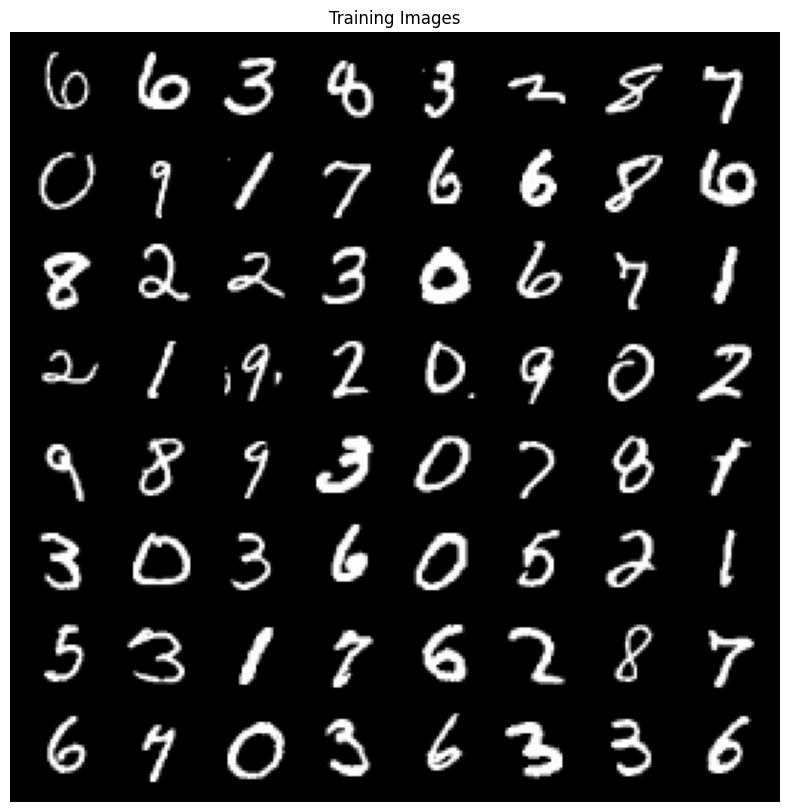

In [10]:
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], padding=5, normalize=True).cpu(),(1,2,0)))
plt.show()

In [11]:
##########################
### MODEL
##########################


class GAN(torch.nn.Module):
  def __init__(self,
               latent_dim=100,
               image_height=28,
               image_width=28,
               color_channels=1):

      super().__init__()

      # self.latent_dim = latent_dim
      self.image_height = image_height
      self.image_width = image_width
      self.color_channels = color_channels


      self.generator=nn.Sequential(
          nn.Linear(latent_dim, 256),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Dropout(0.5),
          nn.Linear(256,image_height*image_width*color_channels),
          nn.Tanh()
      )

      self.discriminator=nn.Sequential(
          nn.Flatten(),
          nn.Linear(image_height*image_width*color_channels, 256),
          nn.LeakyReLU(0.2, inplace=True),
          nn.Dropout(0.5),
          nn.Linear(256,1)
      )
  def generator_forward(self, noise): #noise =z dimensin of NCHW
    noise=torch.flatten(noise, start_dim=1)
    img=self.generator(noise)
    img=img.view(img.size(0),
                 self.color_channels,
                 self.image_height,
                 self.image_width)
    return img
  def discriminator_forward(self, image):
    logits=model.discriminator(image)
    return logits



In [12]:
set_all_seeds(RANDOM_SEED)

model = GAN()
model.to(DEVICE)


optim_gen = torch.optim.Adam(model.generator.parameters(),
                             betas=(0.5, 0.999),
                             lr=GENERATOR_LEARNING_RATE)

optim_discr = torch.optim.Adam(model.discriminator.parameters(),
                               betas=(0.5, 0.999),
                               lr=DISCRIMINATOR_LEARNING_RATE)

In [13]:
log_dict=train_gan_v1(
    num_epochs=NUM_EPOCHS,
    model=model,
    optimizer_gen=optim_gen,
    optimizer_discr=optim_discr,
    latent_dim=100,
    device=DEVICE,
    train_loader=train_loader,
    logging_interval=100,
    save_model='gan_mnist_01.pt'
)

Epoch: 001/050 | Batch 000/469 | Gen/Dis Loss: 0.7180/0.7369
Epoch: 001/050 | Batch 100/469 | Gen/Dis Loss: 0.5922/0.5477
Epoch: 001/050 | Batch 200/469 | Gen/Dis Loss: 0.6314/0.6116
Epoch: 001/050 | Batch 300/469 | Gen/Dis Loss: 0.7818/0.5403
Epoch: 001/050 | Batch 400/469 | Gen/Dis Loss: 1.0955/0.4328
Time elapsed: 0.23 min
Epoch: 002/050 | Batch 000/469 | Gen/Dis Loss: 0.8783/0.4760
Epoch: 002/050 | Batch 100/469 | Gen/Dis Loss: 0.9318/0.4878
Epoch: 002/050 | Batch 200/469 | Gen/Dis Loss: 1.0350/0.4479
Epoch: 002/050 | Batch 300/469 | Gen/Dis Loss: 0.8696/0.5411
Epoch: 002/050 | Batch 400/469 | Gen/Dis Loss: 0.9613/0.5039
Time elapsed: 0.47 min
Epoch: 003/050 | Batch 000/469 | Gen/Dis Loss: 0.9698/0.4804
Epoch: 003/050 | Batch 100/469 | Gen/Dis Loss: 1.2580/0.4694
Epoch: 003/050 | Batch 200/469 | Gen/Dis Loss: 1.0905/0.5039
Epoch: 003/050 | Batch 300/469 | Gen/Dis Loss: 1.0905/0.5311
Epoch: 003/050 | Batch 400/469 | Gen/Dis Loss: 0.9691/0.5211
Time elapsed: 0.68 min
Epoch: 004/050 |

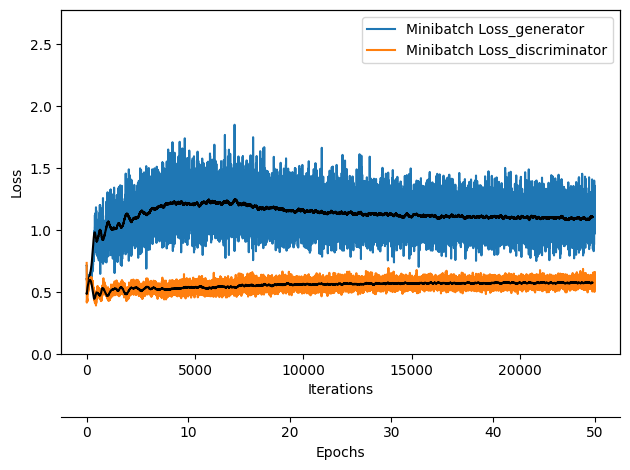

In [14]:
plot_multiple_training_losses(
    losses_list=[log_dict['train_generator_loss_per_batch'],
                 log_dict['train_discriminator_loss_per_batch']],
    num_epochs=NUM_EPOCHS,
    # averaging_iterations=100,
    custom_labels_list=['_generator', '_discriminator']
)

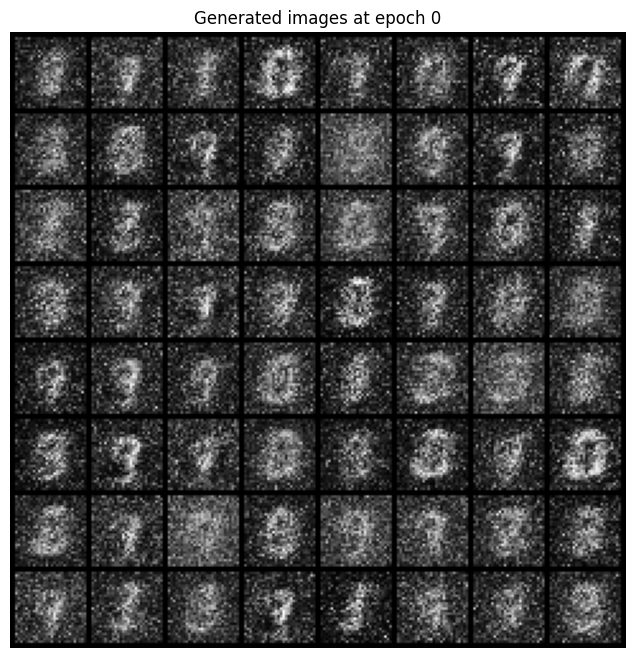

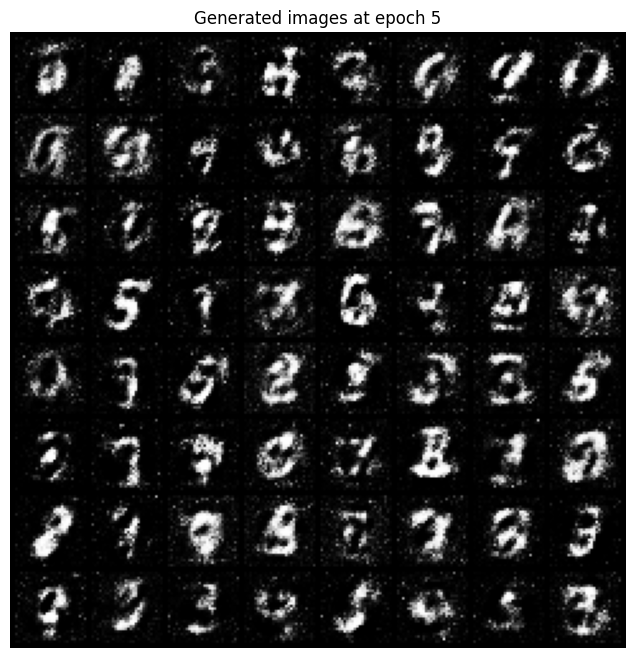

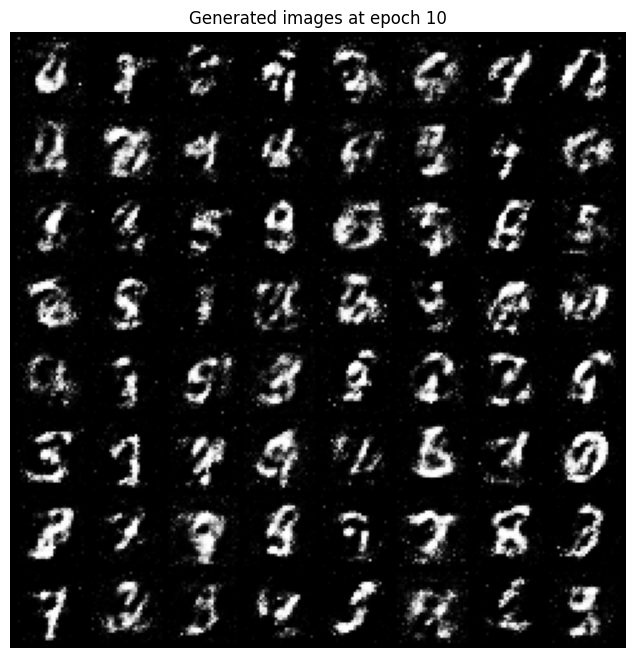

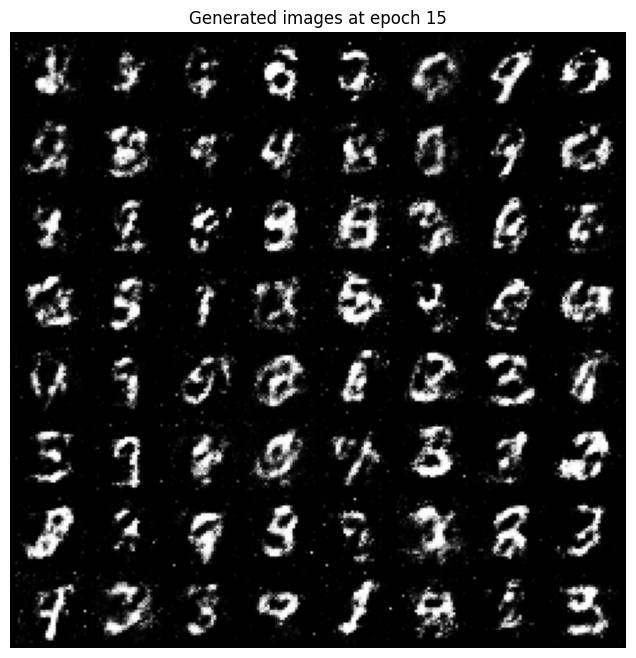

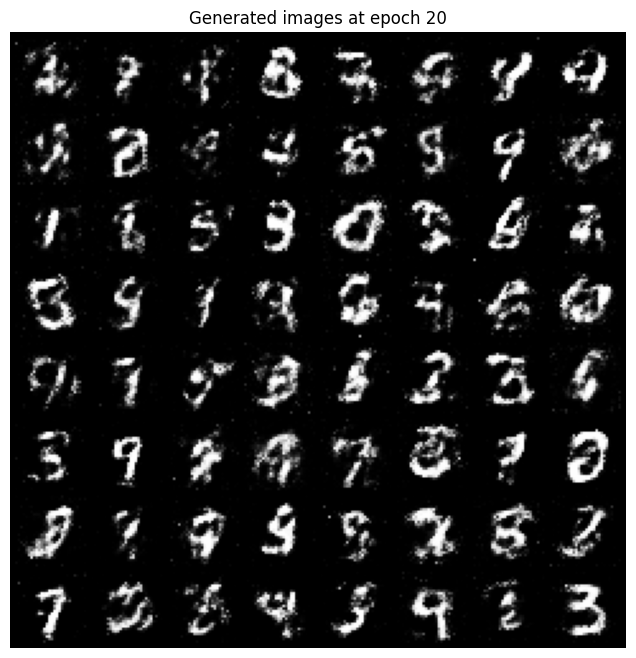

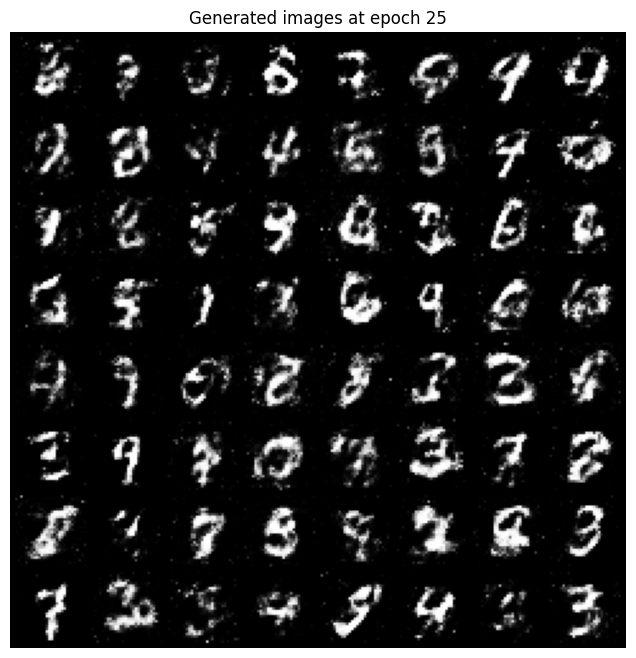

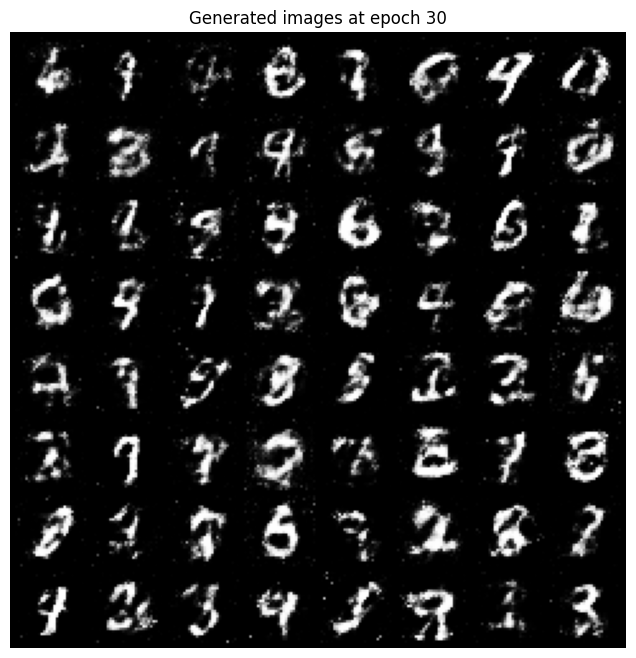

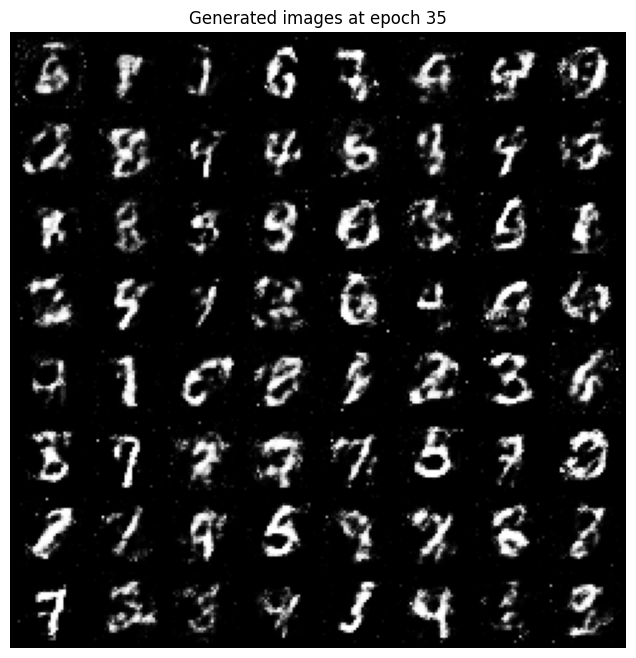

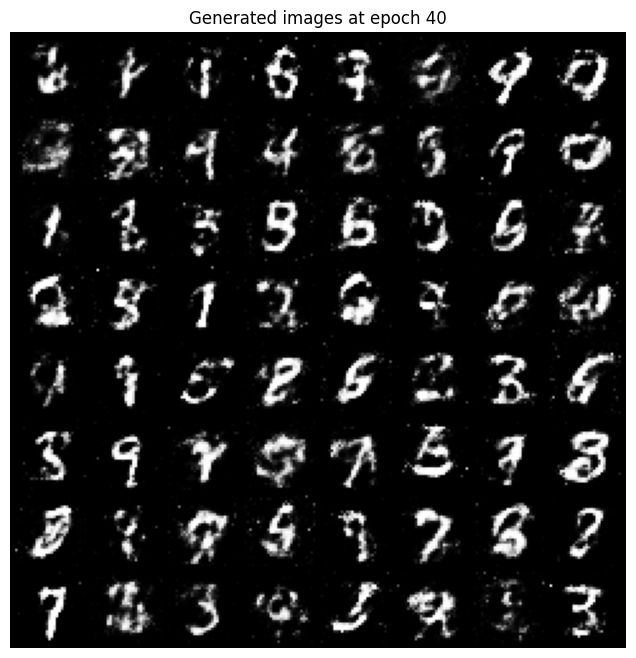

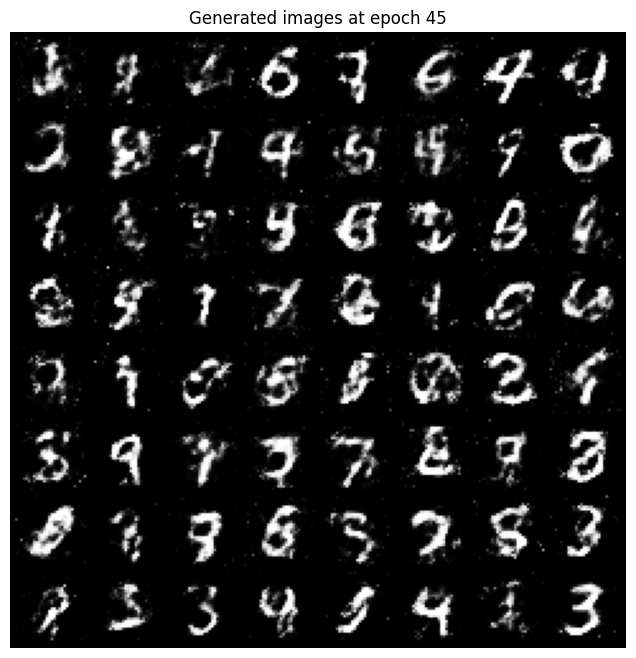

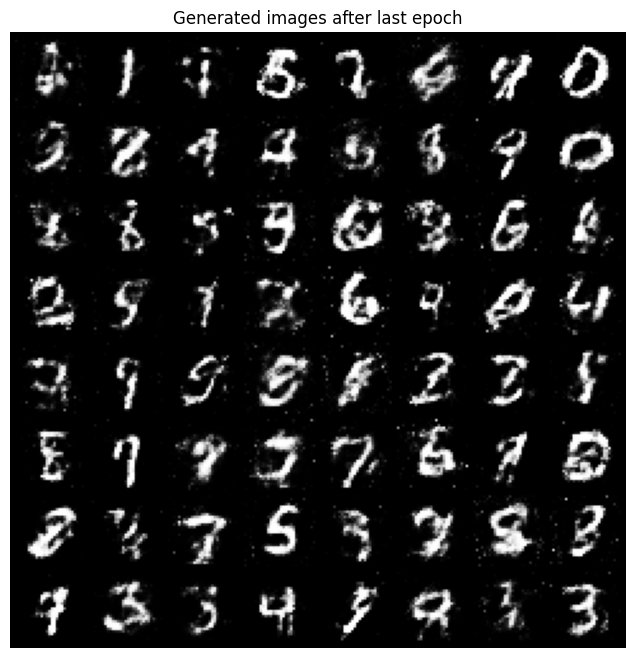

In [15]:
##########################
### VISUALIZATION
##########################

for i in range(0, NUM_EPOCHS, 5):

    plt.figure(figsize=(8, 8))
    plt.axis('off')
    plt.title(f'Generated images at epoch {i}')
    plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][i], (1, 2, 0)))
    plt.show()


plt.figure(figsize=(8, 8))
plt.axis('off')
plt.title(f'Generated images after last epoch')
plt.imshow(np.transpose(log_dict['images_from_noise_per_epoch'][-1], (1, 2, 0)))
plt.show()